In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import math, os, random, cv2
import numpy as np
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH = "E:/Projects/chubrik-kyrsach/datasets/art-mini"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
classes_num = len(train_dataset.class_names)

Found 4651 files belonging to 13 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4661 files belonging to 13 classes.


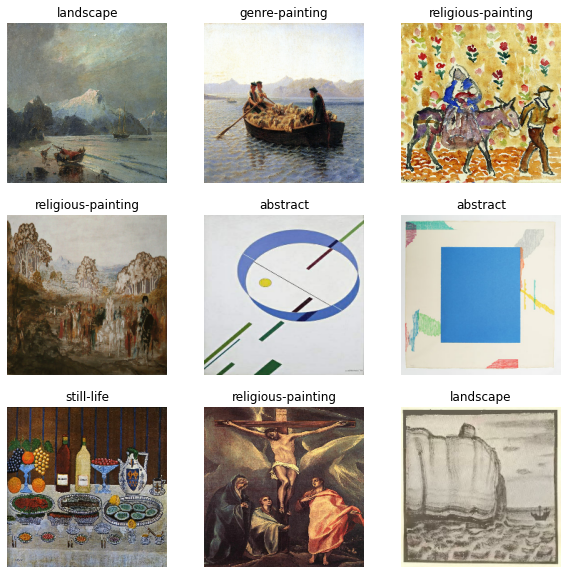

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 117
Number of test batches: 29


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

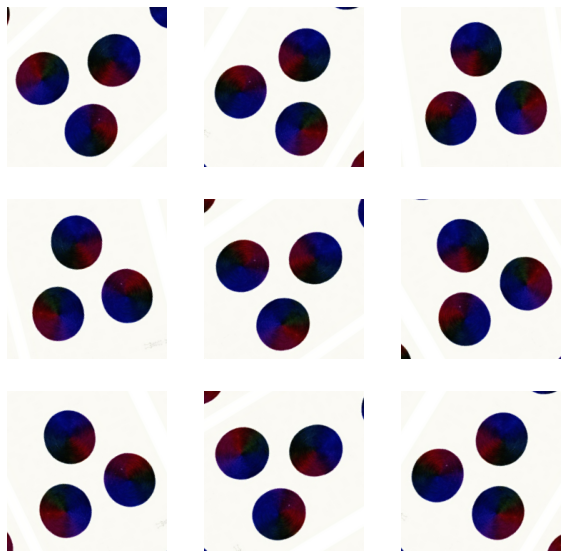

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'ResNetRS101',
 'ResNetRS152',
 'ResNetRS200',
 'ResNetRS270',
 

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
save_path = 'E:/Projects/chubrik-kyrsach/saves/MobileNetV3Large'

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 960)


In [15]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [17]:
prediction_layer = tf.keras.layers.Dense(classes_num)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 13)                12493 

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = len(train_dataset)

loss0, accuracy0 = model.evaluate(validation_dataset)

117/117 [==============================] - 14s 80ms/step - loss: 3.2669 - accuracy: 0.0828


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.27
initial accuracy: 0.08


In [24]:
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)]

In [25]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset, callbacks=get_callbacks())

Epoch 1/146
146/146 [==============================] - 27s 168ms/step - loss: 2.1281 - accuracy: 0.3621 - val_loss: 1.6200 - val_accuracy: 0.4851
Epoch 2/146
146/146 [==============================] - 24s 163ms/step - loss: 1.5092 - accuracy: 0.5126 - val_loss: 1.4161 - val_accuracy: 0.5400
Epoch 3/146
146/146 [==============================] - 24s 163ms/step - loss: 1.3431 - accuracy: 0.5599 - val_loss: 1.3104 - val_accuracy: 0.5714
Epoch 4/146
146/146 [==============================] - 24s 163ms/step - loss: 1.2565 - accuracy: 0.5801 - val_loss: 1.2601 - val_accuracy: 0.5896
Epoch 5/146
146/146 [==============================] - 24s 163ms/step - loss: 1.1819 - accuracy: 0.6095 - val_loss: 1.2423 - val_accuracy: 0.5963
Epoch 6/146
146/146 [==============================] - 24s 163ms/step - loss: 1.1334 - accuracy: 0.6179 - val_loss: 1.2092 - val_accuracy: 0.6049
Epoch 7/146
146/146 [==============================] - 24s 163ms/step - loss: 1.0872 - accuracy: 0.6364 - val_loss: 1.1928 -

Epoch 57/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7723 - accuracy: 0.7280 - val_loss: 1.2160 - val_accuracy: 0.6341
Epoch 58/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7565 - accuracy: 0.7336 - val_loss: 1.2171 - val_accuracy: 0.6359
Epoch 59/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7443 - accuracy: 0.7336 - val_loss: 1.2515 - val_accuracy: 0.6293
Epoch 60/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7619 - accuracy: 0.7334 - val_loss: 1.2251 - val_accuracy: 0.6368
Epoch 61/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7691 - accuracy: 0.7312 - val_loss: 1.2205 - val_accuracy: 0.6381
Epoch 62/146
146/146 [==============================] - 24s 163ms/step - loss: 0.7643 - accuracy: 0.7366 - val_loss: 1.2203 - val_accuracy: 0.6402
Epoch 63/146
146/146 [==============================] - 24s 164ms/step - loss: 0.7488 - accuracy: 0.7390 - val_loss: 1

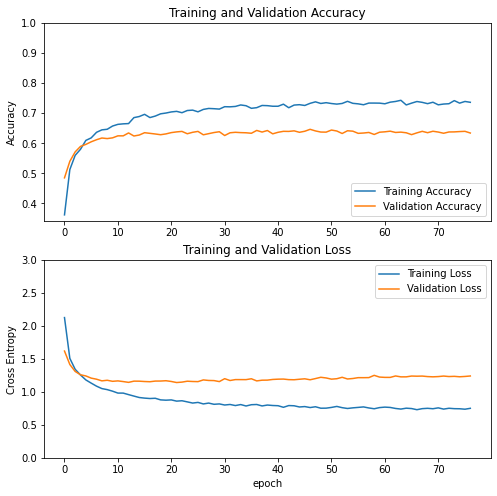

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
loss_test, accuracy_test = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_test)

29/29 [==============================] - 3s 92ms/step - loss: 1.2136 - accuracy: 0.6196
Test accuracy : 0.6196120977401733


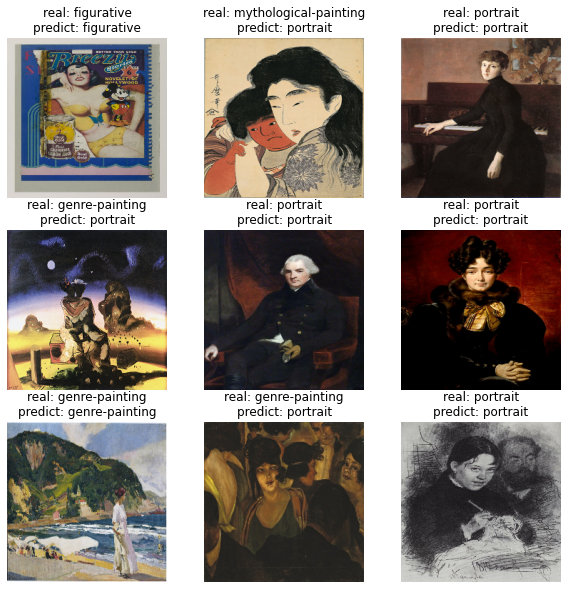

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

def arrayToIndex(a):
    l = list(a)
    return l.index(max(l))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = arrayToIndex(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index]
    plt.title(label)
    plt.axis("off")

In [29]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 13)                12493 

In [31]:
len(model.trainable_variables)

94

In [32]:
trained_epochs = len(history.epoch)
fine_tune_epochs = max(10, trained_epochs * 0.05)
total_epochs =  trained_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=get_callbacks())

Epoch 77/87
146/146 [==============================] - 34s 200ms/step - loss: 0.7456 - accuracy: 0.7317 - val_loss: 1.2081 - val_accuracy: 0.6362
Epoch 78/87
146/146 [==============================] - 29s 193ms/step - loss: 0.6554 - accuracy: 0.7702 - val_loss: 1.2338 - val_accuracy: 0.6381
Epoch 79/87
146/146 [==============================] - 29s 192ms/step - loss: 0.5823 - accuracy: 0.7957 - val_loss: 1.2192 - val_accuracy: 0.6437
Epoch 80/87
146/146 [==============================] - 29s 193ms/step - loss: 0.5145 - accuracy: 0.8168 - val_loss: 1.2345 - val_accuracy: 0.6507
Epoch 81/87
146/146 [==============================] - 29s 193ms/step - loss: 0.4626 - accuracy: 0.8372 - val_loss: 1.2671 - val_accuracy: 0.6480
Epoch 82/87
146/146 [==============================] - 29s 193ms/step - loss: 0.4144 - accuracy: 0.8570 - val_loss: 1.3017 - val_accuracy: 0.6464
Epoch 83/87
146/146 [==============================] - 29s 193ms/step - loss: 0.3658 - accuracy: 0.8710 - val_loss: 1.3122 -

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

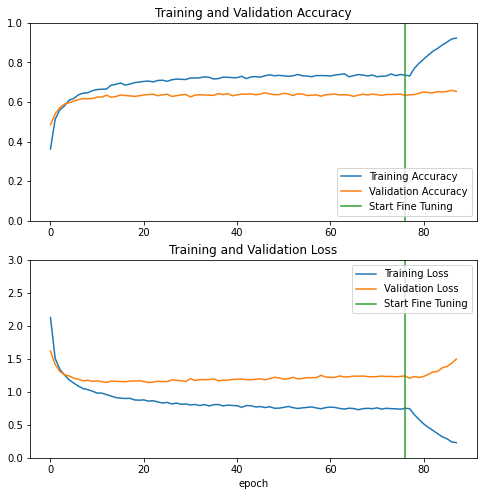

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([trained_epochs-1,trained_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([trained_epochs-1,trained_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss_test, accuracy_test = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_test)

29/29 [==============================] - 3s 89ms/step - loss: 1.5644 - accuracy: 0.6455
Test accuracy : 0.6454741358757019


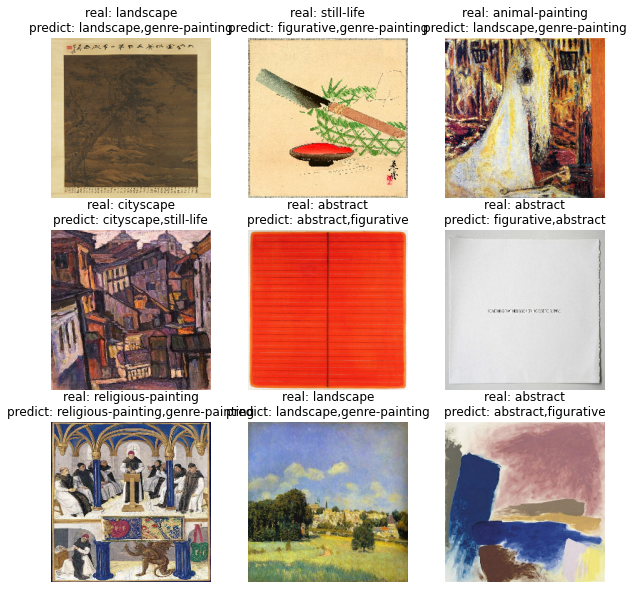

In [36]:
def arrayToIndexSort(predictions):
    l = list(predictions)
    cp = list(predictions)
    l.sort(reverse=True)
    return cp.index(l[0]), cp.index(l[1])

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = arrayToIndexSort(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index[0]] + ',' + class_names[label_index[1]]
    plt.title(label)
    plt.axis("off")

In [37]:
def my_evaluate():
    total_count = 0
    good_predict_count = 0
    for image_batch, label_batch in test_dataset.as_numpy_iterator():
        total_count += len(label_batch)
        predictions = model.predict_on_batch(image_batch)
        for i in range(len(label_batch)):
            real_label = label_batch[i]
            predicted_labels = arrayToIndexSort(predictions[i])
            if real_label in predicted_labels:
                good_predict_count += 1

    print('Test images count: {}'.format(total_count))
    print('My accuracy :', good_predict_count / total_count)

my_evaluate()

Test images count: 928
My accuracy : 0.8135775862068966


In [38]:
model.save_weights(save_path)